In [101]:
import numpy as np
import pandas as pd
import cPickle as pickle
from final_model_fit import *
from plot_confusion_matrix import plot_confusion_matrix
from plot_classification_report import plot_classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import colors as mcolors
import seaborn

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('../data/master.csv')
processed_df, X_train, X_test, y_train, y_test = process_frame(df)

/Users/Philip/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13,23,28,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
mask_pass = df['PlayType'] == 'PASS'
mask_rush = (df['PlayType'] == 'RUSH') | (df['IsRush'] == 1)
passrush_df = df[mask_pass | mask_rush]

In [4]:
model_filename = '../models/gb_final.p'
model = pickle.load(open(model_filename, 'rb'))

In [5]:
def get_sorted_features(model, n_features):
    feature_importance = {}
    for label, importance in zip(processed_df.columns, model.feature_importances_):
        feature_importance[label] = importance

    return sorted(feature_importance.items(), key=lambda x: (-x[1]))[:n_features + 1]

get_sorted_features(model, 10)

[('ToGo', 0.071962741288327636),
 ('Left_in_game', 0.069232227240320507),
 ('Left_in_half', 0.064863929350025426),
 ('YardLine', 0.060312621872107265),
 ('Score_differential', 0.038412280641645175),
 ('Formation_UNDER CENTER', 0.027289984673762667),
 ('Away_total_score', 0.026836655341374412),
 ('Home_total_score', 0.025389802500948751),
 ('Formation_SHOTGUN', 0.020619944378100896),
 ('Last_two_plays_IsPass', 0.019397152301762612),
 ('Humidity', 0.017496017097208799)]

In [6]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

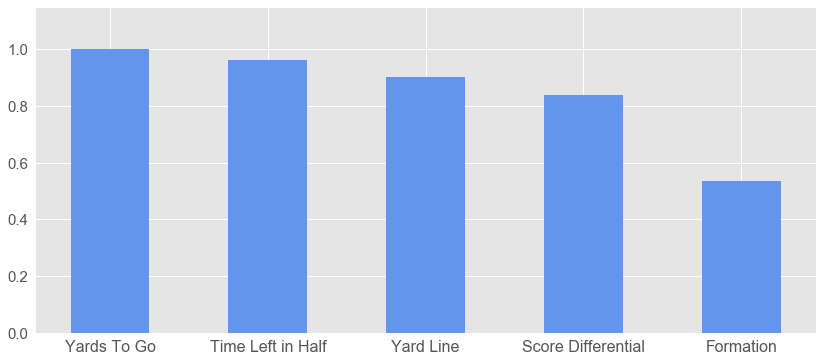

In [7]:
# plot relative feature importances
def plot_nfeature_importances(model, n_features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = list(processed_df.columns[indices])[:n_features]
    top_ten = importances[indices][:n_features]
    top_ten = top_ten / float(top_ten.max())
    fig, ax = plt.subplots(1, figsize=(14, 6))
    ax.set_ylim(0, 1.15)
    ax.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0], fontsize=15)
    fig_feature_names = ['', 'Yards To Go', 'Time Left in Half', 'Yard Line', 'Score Differential', 'Formation']
    ax.bar(range(1,len(fig_feature_names)), top_ten, width=0.5, align="center", color=colors['cornflowerblue'])
    ax.set_xticklabels(fig_feature_names, fontsize=16)
    plt.savefig('features.png', dpi=300)
    plt.show()

    
plot_nfeature_importances(model, 5)

In [8]:
# calculate pass play average by formation
shotgun_df = df[df['Formation'] == 'SHOTGUN']
undercenter_df = df[df['Formation'] == 'UNDER CENTER']
noh_shotgun_df = df[df['Formation'] == 'NO HUDDLE SHOTGUN']
noh_undercenter_df = df[df['Formation'] == 'NO HUDDLE']

formation_dfs = [shotgun_df, undercenter_df, noh_shotgun_df, noh_undercenter_df]
pass_ratios = [dataframe['IsPass'].mean() for dataframe in formation_dfs]
rush_ratios = [dataframe['IsRush'].mean() for dataframe in formation_dfs]

"""
Insights: 
- Only 23% of plays from under center result in a pass!
- Pass ratios for shotgun vs. no huddle shotgun are almost identical
- There are 28% more pass plays run out of no huddle under center plays vs. under center (with huddle)
    - This suggests that no huddle under center plays more often result in play action pass attempts
"""

'\nInsights: \n- Only 23% of plays from under center result in a pass!\n- Pass ratios for shotgun vs. no huddle shotgun are almost identical\n- There are 28% more pass plays run out of no huddle under center plays vs. under center (with huddle)\n    - This suggests that no huddle under center plays more often result in play action pass attempts\n'

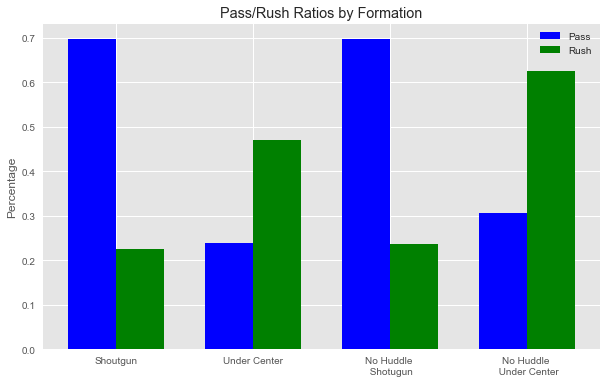

In [9]:
# plot pass play average by formation
def plot_formations(pass_ratios, rush_ratios):

    ind = np.arange(4)
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(ind, pass_ratios, width, color='b')
    rects2 = ax.bar(ind + width, rush_ratios, width, color='g')

    ax.set_ylabel('Percentage')
    ax.set_title('Pass/Rush Ratios by Formation')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('Shoutgun', 'Under Center', 'No Huddle \n Shotugun', 'No Huddle \n Under Center'))

    ax.legend((rects1[0], rects2[0]), ('Pass', 'Rush'))
    
    plt.show()

plot_formations(pass_ratios, rush_ratios)

In [12]:
# Create absolute minute column
# q1 minute = absolute value of (minute - 15)
q1_mask = passrush_df['Quarter'] == 1.
passrush_df.loc[q1_mask, 'abs_minute'] = passrush_df['Minute'].apply(lambda x: abs(x-15))

q2_mask = passrush_df['Quarter'] == 2
passrush_df.loc[q2_mask, 'abs_minute'] = passrush_df['Minute'].apply(lambda x: abs(x-15) + 15)

q3_mask = passrush_df['Quarter'] == 3
passrush_df.loc[q3_mask, 'abs_minute'] = passrush_df['Minute'].apply(lambda x: abs(x-15) + 30)

q4_mask = passrush_df['Quarter'] == 4
passrush_df.loc[q4_mask, 'abs_minute'] = passrush_df['Minute'].apply(lambda x: abs(x-15) + 45)

q5_mask = passrush_df['Quarter'] == 5
passrush_df.loc[q5_mask, 'abs_minute'] = passrush_df['Minute'].apply(lambda x: abs(x-15) + 60)

/Users/Philip/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Philip/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


'\nInsights:\n- Across all quarters teams try to establish their run game, then open up through the air as time elapses\n- As time goes on pass attempts increase\n- Quarters 2 and 4 (before halves) experience much higher pass attempts on average\n- In the last minute of overtime over 90% of plays are pass attempts\n'

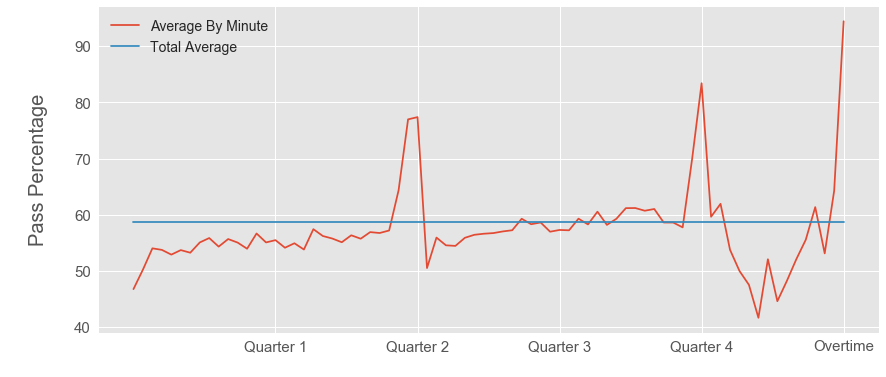

In [13]:
# Pass Play Average by Minute
fig, ax = plt.subplots(1, figsize=(14, 6))
ispass_df = passrush_df.groupby('abs_minute')['IsPass'].mean()
ax.plot(ispass_df.index, ispass_df, label='Average By Minute')
ax.plot(ispass_df.index, [0.5866371969545181]*76, label='Total Average')
ax.set_title('\n\n', fontsize=22)
ax.set_ylabel('\nPass Percentage\n', fontsize=20)
ax.set_yticklabels([30,40,50,60,70,80,90], fontsize=15)
ax.set_xticks([15,30,45,60,75])
ax.set_xticklabels(['Quarter 1\n', 'Quarter 2', 'Quarter 3', 'Quarter 4', 'Overtime'], fontsize=15)
ax.legend(fontsize=14)
plt.savefig('time.png', dpi=300)

"""
Insights:
- Across all quarters teams try to establish their run game, then open up through the air as time elapses
- As time goes on pass attempts increase
- Quarters 2 and 4 (before halves) experience much higher pass attempts on average
- In the last minute of overtime over 90% of plays are pass attempts
"""

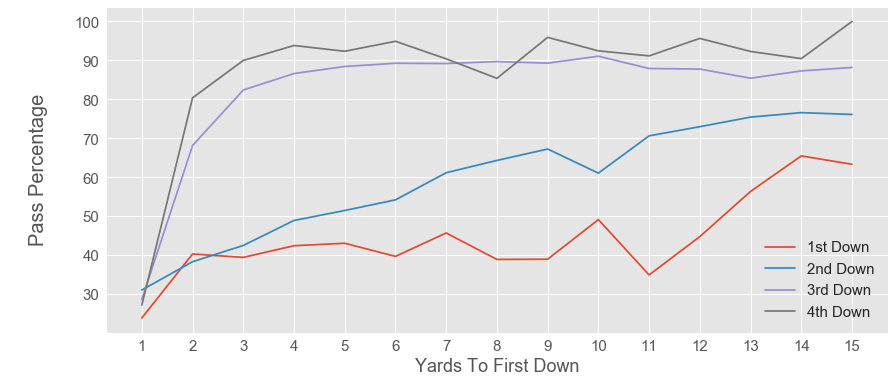

In [66]:
# Pass Play Average by Down and Distance
mask = (passrush_df['ToGo'] < 16) & (passrush_df['ToGo'] != 0)
downdistance_df = passrush_df[mask]
downdistance_df = downdistance_df.groupby(['ToGo','Down'])['IsPass'].mean().unstack()
fig, ax = plt.subplots(1, figsize=(14, 6))
ax.plot(downdistance_df.index, downdistance_df)
ax.set_xticks(range(1,16))
ax.set_xticklabels(range(1,16), fontsize=15)
ax.set_xlabel('Yards To First Down', fontsize=18)
ax.set_yticks(np.arange(0.3, 1.1, 0.1))
ax.set_yticklabels(np.arange(30, 110, 10), fontsize=15)
ax.set_ylabel('\nPass Percentage\n', fontsize=20)
ax.legend(['1st Down', '2nd Down', '3rd Down', '4th Down'], loc=4, fontsize=15)
plt.savefig('downanddistance.png', dpi=300)

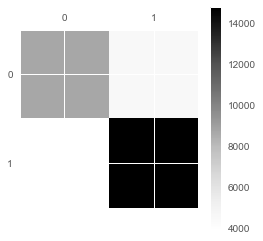

In [67]:
X_test = pickle.load(open('../models/X_test.p', 'rb'))
y_test = pickle.load(open('../models/y_test.p', 'rb'))

In [82]:
# calculate evaluation metrics
accuracy, baseline, class_report, conf_matrix = return_model_scores(model, X_test, y_test)

Confusion matrix, without normalization
[[ 8752  4488]
 [ 3898 14805]]


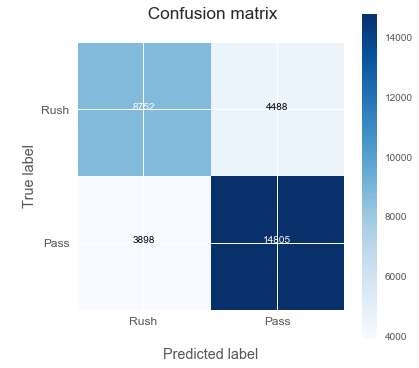

In [99]:
plt.figure(figsize=(6, 6))
plot_confusion_matrix(conf_matrix, classes=['Rush', 'Pass'], title=' Confusion matrix\n')
plt.savefig('confusion_matrix.png', dpi=300)

ValueError: need more than 1 value to unpack

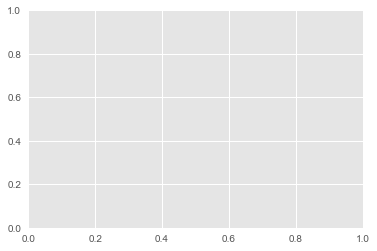

In [103]:
plot_classification_report(class_report, 'Classification Report')

In [105]:
print class_report

             precision    recall  f1-score   support

        0.0       0.69      0.66      0.68     13240
        1.0       0.77      0.79      0.78     18703

avg / total       0.74      0.74      0.74     31943



In [29]:
# partial plots

In [ ]:
# roc_auc_score